# Synaptic Plasticity

In [110]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

# we use this function from the last exercise
def create_poisson_process(time_steps, rate,dt):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)'''
    
    rate = rate*1e-3 # rate is usually given in 1/s , we need 1/ms
    
    x = np.zeros(time_steps).astype(int)
    x[np.random.rand(time_steps) <= rate*dt] = 1

    return x

def transform_to_event_input(binned_spikes, bin_size=0.1):
    ''' transform binned_spike [spike train arrays, like np.array([0,0,0,1,0,0,1,0,1]) ]
        given the size of the bin bin_size 
        to arrays that cotain the spike times (and are easy to plot with the matplotlib event_plot function )'''
    
    bin_offset = bin_size/2.
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times

# Spike-Time Dependent Plasticity (STDP)




In [138]:
def plastic_synapse_pairwise(
                    pre_spike_train, 
                    post_spike_train,
                    A_plus = 0.008, 
                    A_minus = 0.008, 
                    tau_plus = 20, 
                    tau_minus = 20, 
                    w_start = 0.1, 
                    w_max = 2,
                    dt=0.1
    ):
    """
    Spike-time dependent plasticity

    Args:
    pre_spike_train   : total spike train input from presynaptic neuron
    post_spike_train  : total spike train from postsynaptic neuron
    A_plus            : maximum weight change for positive delta_t
    A_minus           : maximum weight change for negative delta t
    tau_plus          : time constant for positive delta_t (in ms)
    tau_minus         : time constant for negative delta_t (in ms)
    w_start           : starting weight from pre to post (in nS)
    w_max             : maximum weight 
    dt                : time step in ms

    Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

    """

    time_steps = np.max([len(pre_spike_train), len(post_spike_train)])
    # Initialize
    w = np.zeros(time_steps)
    w[0] = w_start
    M = np.zeros(time_steps) # postsynaptic activity trace
    P = np.zeros(time_steps) # presynaptic activity trace

    
    Prel = np.zeros(time_steps)
    Ps = np.zeros(time_steps)
    
    t = np.zeros(time_steps)

    # simulation (loop through the time steps)
    for it in range(time_steps - 1):
        # Compute dP
        # the first part is the exponential relaxation back to baseline with time constant tau_f
        # the second part is checking for spikes and increasing P if there is one (see equation x)
        dP = -(P[it] / tau_plus) * dt  + A_plus * pre_spike_train[it + 1]
        P[it + 1] = P[it] + dP
        
        # Compute dM
        # same as for u but R goes back to 1, not to 0
        dM = -(M[it] / tau_minus) * dt  + A_minus * post_spike_train[it + 1]
        M[it + 1] = M[it] + dM
        
        # Compute dw
        weight_change_pre_spike = pre_spike_train[it + 1] * M[it + 1] 
        weight_change_post_spike = post_spike_train[it + 1] * P[it + 1]
        
        
        w[it + 1] = np.max([w[it] + weight_change_pre_spike, 0])
        w[it + 1] = np.min([w[it+1] + weight_change_post_spike, w_max])
        
        
        t[it + 1] = t[it] + dt

    return t, w, P, M


def generate_STDP_scenario(
    scenario_name = 'default', 
    return_list = False,
    dt = 0.1):
    
    all_scenario_names = ['default', 'Poisson - rate 20 Hz']
    
    
    if return_list:
        return all_scenario_names 
    
    if scenario_name not in all_scenario_names:
        raise Error
    
    if scenario_name == 'default':
        
        pre_spike_times = np.array([50,100,200,250])
        post_spike_times = np.array([60,110,190,240])
        
    if scenario_name == 'Poisson - rate 20 Hz':
        _, pre_spike_times = transform_to_event_input(
                binned_spikes = create_poisson_process(time_steps = 3000, rate=20,dt=dt), bin_size=dt)
        
        _, post_spike_times = transform_to_event_input(
                binned_spikes = create_poisson_process(time_steps = 3000, rate=20,dt=dt), bin_size=dt)

    
    return pre_spike_times, post_spike_times
    

### Task X

In [142]:
def illustrate_STDP_over_long_runs(show_plot = True):
    """

    Args:
    Poi_or_reg : Poisson or regular input spiking trains
    rate       : Rate of input spikes, Hz
    U0         : synaptic release probability at rest
    tau_d      : synaptic depression time constant of x [ms]
    tau_f      : synaptic facilitation time constantr of u [ms]
    """
    
    dt = 0.1
    
    tau_plus = 20
    tau_minus = 20
    
    A_plus = 0.2
    A_minus = -0.2
    
    w_max = 2
    w_start = 0.1
    
    
    pre_spike_times, post_spike_times = generate_STDP_scenario(scenario_name=scenario_name, dt=dt)
        
    sim_time = np.max(np.hstack([pre_spike_times,post_spike_times])) + np.max([tau_plus,tau_minus])*3
    # we choose the sim time so that we capture most of the decay of the P and M traces after the last spike
    
    time_steps = int(np.floor(sim_time/dt))
    
    
    
    def transform_spike_times_to_spike_trains(spike_times):
        spike_train = np.zeros(time_steps)
        spike_train[(spike_times/dt).astype(int)] = 1
        return spike_train
    
    pre_spike_train = transform_spike_times_to_spike_trains(pre_spike_times)
    post_spike_train = transform_spike_times_to_spike_trains(post_spike_times)
    

    t, w, P, M = plastic_synapse_pairwise(
                    A_plus = A_plus, 
                    A_minus = A_minus, 
                    tau_plus = tau_plus, 
                    tau_minus = tau_minus, 
                    w_start = w_start, 
                    w_max = w_max,
                    pre_spike_train=pre_spike_train, 
                    post_spike_train=post_spike_train,
                    dt = dt)

    if show_plot:
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,figsize=(12, 6), 
                                            gridspec_kw={'height_ratios': [1, 3,3,3,1]},
                                           sharex = True)

        ax1.eventplot(pre_spike_times, color='#0570B0') 
        ax1.set(
            title = 'Presynaptic Spikes',
            xlim = (0, sim_time),
            yticks = [],
        )


        ax2.plot(t, P, '#238B45', label='R')
        ax2.set(
            ylabel = r'$P$ (a.u)',
        )


        ax3.plot(t, w, 'k', label='STP synapse')
        ax3.set(
            ylabel = 'w in nS',
            ylim = np.max(w) * np.array([-0.1,1.1]),
        )


        ax4.plot(t, M, '#E31A1C', label='M')
        ax4.set(
#             ylim = (-0.1,1.1),
            ylabel = r'$M$ (a.u)',
        )
    
    

        ax5.eventplot(post_spike_times, color='#EC7014') 
        ax5.set(
            title = 'Postsynaptic Spikes',
            xlim = (0, sim_time),
            yticks = [],
            xlabel = 'time in ms'
        )
        
        for ax in [ax2, ax3, ax4]:
            for spike_times, cc in zip([pre_spike_times, post_spike_times],['#0570B0', '#EC7014']):
                for spkt in spike_times:
                    ax.axvline(x=spkt, color = cc, linestyle = '--',linewidth=0.5)
            
    plt.tight_layout()



widgets.interactive(illustrate_STDP, 
                    scenario_name = generate_STDP_scenario(return_list=True))

interactive(children=(Dropdown(description='scenario_name', options=('default', 'Poisson - rate 20 Hz'), value…

In [165]:
def illustrate_STDP_long_run(
                    tau_plus = 20,
                    tau_minus = 20,
                    A_plus = 0.2,
                    A_minus = -0.2,
    ):
    """

    Args:
    scenario_name : name of the pre- and post-spike train scenario
    """
    
    dt = 0.1
    
    w_max = 2
    w_start = 1
    
    time_steps = 10_000
    
    sim_time = time_steps*dt
    
    w_array = np.array([])
    
    for ii in range(30):
        _, pre_spike_times = transform_to_event_input(
                    binned_spikes = create_poisson_process(time_steps = time_steps, rate=60,dt=dt), bin_size=dt)

        _, post_spike_times = transform_to_event_input(
                    binned_spikes = create_poisson_process(time_steps = time_steps, rate=60,dt=dt), bin_size=dt)


        def transform_spike_times_to_spike_trains(spike_times):
            spike_train = np.zeros(time_steps)
            spike_train[(spike_times/dt).astype(int)] = 1
            return spike_train

        pre_spike_train = transform_spike_times_to_spike_trains(pre_spike_times)
        post_spike_train = transform_spike_times_to_spike_trains(post_spike_times)


        t, w, P, M = plastic_synapse_pairwise(
                        A_plus = A_plus, 
                        A_minus = A_minus, 
                        tau_plus = tau_plus, 
                        tau_minus = tau_minus, 
                        w_start = w_start, 
                        w_max = w_max,
                        pre_spike_train=pre_spike_train, 
                        post_spike_train=post_spike_train,
                        dt = dt)
        if w_array.size == 0:
            w_array = w
        else:
            w_array = np.vstack([w_array,w])
            
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3), 
                                        gridspec_kw={'width_ratios': [1, 4]})
    
    x_minus = np.linspace(-np.max([tau_minus,tau_plus])*4,0,1000)
    x_plus = -1*x_minus[::-1]
    
    ax1.plot(x_minus, A_minus*np.exp(x_minus/tau_minus), color='#E31A1C') 
    ax1.plot(x_plus, A_plus*np.exp(-x_plus/tau_plus), color='#238B45') 
    
    ax1.set(
        title = 'Learning Windows',
        xlabel = r'$\Delta t$ in ms',
        ylabel = 'weight change in a.u.'
    )

    print (w_array.shape)

    ax2.plot(t, w_array.T, 'k', alpha = 0.2, linewidth = 0.5)
    ax2.plot(t,np.mean(w_array, axis =0),'k')
    ax2.set(
        ylabel = 'w in nS',
        ylim = w_max * np.array([-0.1,1.1]),
    )

    plt.tight_layout()




(30, 10000)


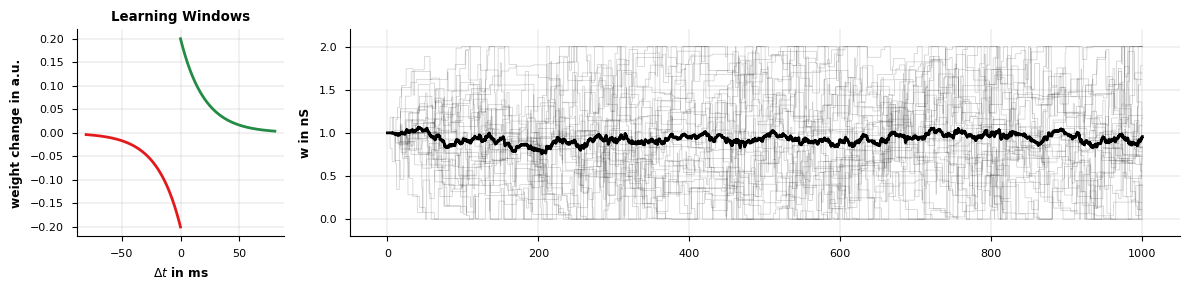

In [164]:
illustrate_STDP_long_run(tau_plus = 20,
                    tau_minus = 20,
                    A_plus = 0.2,
                    A_minus = -0.2)

(30, 10000)


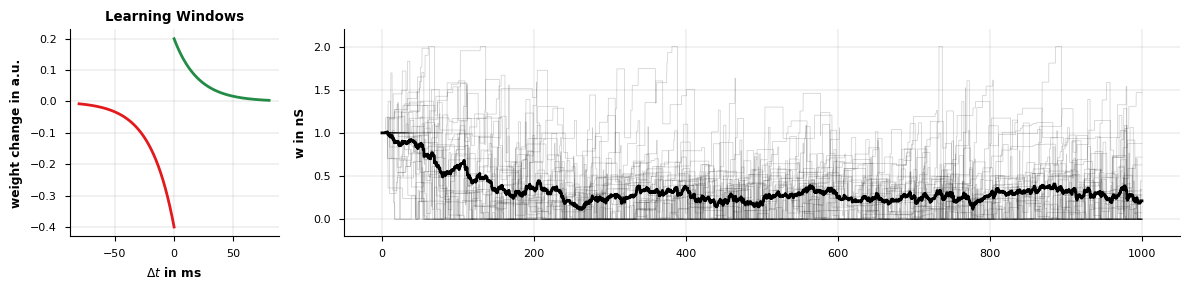

In [166]:
illustrate_STDP_long_run(tau_plus = 20,
                    tau_minus = 20,
                    A_plus = 0.2,
                    A_minus = -0.4)

(30, 10000)


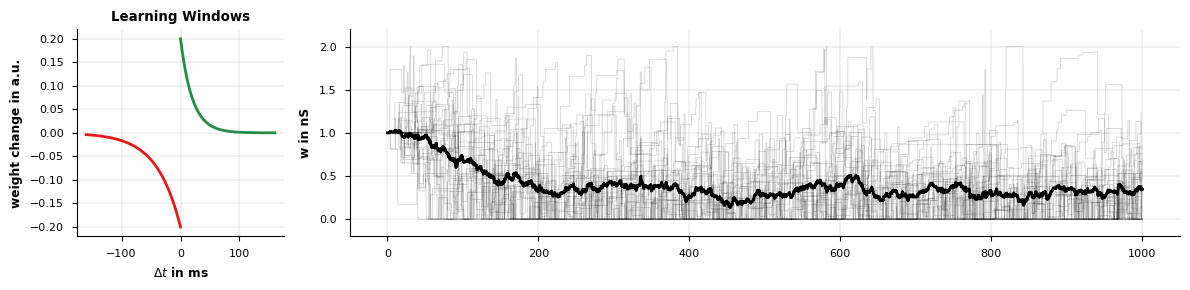

In [167]:
illustrate_STDP_long_run(tau_plus = 20,
                    tau_minus = 40,
                    A_plus = 0.2,
                    A_minus = -0.2)

# Short Term Plasticity (STP)

We now look at short term plasticity (STP) which can have a facilitating (short term facilitation, STF) or a depressing (short term depression, STD) effect. More specifically we look at the **Tsodyks-Markram Model**.
The reasoning comes from the idea that increased activity at the synapse increases the release probability (facilitation) while at the same time there is only a limited pool of resources that can only be refreshed at a certain rate and thus can shrink over time (depression). 
Overall, these dynamics affect the release probability of the presynaptic site.

In formulas it looks like this: 
\begin{eqnarray}
&& \frac{du}{dt} &=& -\frac{u}{\tau_f} \qquad \text{if spike: } u \leftarrow U_0(1-u)) \\[.5mm]
&& \frac{dR}{dt} &=& \frac{1-R}{\tau_d} \qquad \text{if spike: } R \leftarrow u\,R \qquad \qquad \\[.5mm]
&& P_{rel} &=& u\,R \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad (1)  \\[.5mm]
&& \frac{dP_s}{dt} &=& -\frac{P_s}{\tau_syn} \qquad \text{if spike: } P_s \leftarrow 1 \\[.5mm]
&& g_{syn} &=& g_{max}\,P_s\,P_{rel}
\end{eqnarray}


In the next task we will explore how these formulas interact. 
$u$ describes the release probability. 
$R$ describes the remaining pool of resources. The coupling between the two (look at how R is upated each spike: $R\leftarrow u\,R$) describes the fact that if there is a higher release probability $u$ a higher fraction of the available resources is used per spike. 
Keep this idea in mind when working on the following task

### Task X

We want to explore how the paramters of the Tsodyks-Markram Model. 
First, look at the implementation of the _dynamic_synapse_ function. Does it makes sense to you? It closely follows the equation shown above.

Then try to find two distinct paramter regimes, one where you see STD and one where you see STF. Before moving around the sliders, think about the effect each paramter should have on the outcome and see whether your prediction is correct.


In [68]:
def illustrate_STD(Poisson_instead_of_regular=False, rate=20., U0=0.5,
                 tau_d=100., tau_f=50., show_plot = True):
    """

    Args:
    Poi_or_reg : Poisson or regular input spiking trains
    rate       : Rate of input spikes, Hz
    U0         : synaptic release probability at rest
    tau_d      : synaptic depression time constant of x [ms]
    tau_f      : synaptic facilitation time constantr of u [ms]
    """

    T_simu = 11.0/(rate*1e-3)  # 10 spikes in the time window (we skip the first later on) (1e-3 since rate is in Hz)
    dt = 0.1
    time_steps = int(np.floor(T_simu/dt))  
    
    if Poisson_instead_of_regular:
        # Poisson type spike train
        pre_spike_train = create_poisson_process(time_steps=time_steps, rate=rate, dt=dt)
    else:
        # Regular firing rate
        isi_num = int(1/(rate*1e-3)/dt)  # number of dt
        pre_spike_train = np.zeros(time_steps).astype(int)
        pre_spike_train[isi_num::isi_num] = 1

    t, u, R, g = dynamic_synapse(g_max=1.2, tau_syn=5., U0=U0,
                        tau_d=tau_d, tau_f=tau_f,
                        pre_spike_train=pre_spike_train,
                        dt=dt)

    if show_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12, 6), 
                                            gridspec_kw={'height_ratios': [1, 3,3]},
                                           sharex = True)

        spikes = pre_spike_train > 0
        spike_times = t[spikes]  #spike times
        ax1.eventplot(spike_times) 
        ax1.set(
            title = 'Presynaptic Spikes',
            xlim = (0, T_simu),
            yticks = [],
        )


        ax2.plot(t, R, '#045a8d', label='R')
        ax2.plot(t, u, '#a50f15', label='u')
        ax2.legend(loc='best')

        ax2.set(
            ylim = (-0.1,1.1),
            ylabel = r'$R$ or $u$ (a.u)',
        )


        ax3.plot(t, g, 'k', label='STP synapse')
        ax3.set(
            xlabel = 'Time in ms',
            ylabel = 'g in nS',
        )

        plt.tight_layout()
    
    if not Poisson_instead_of_regular:
        return g[isi_num], g[10*isi_num]




def dynamic_synapse(g_max, tau_syn, U0, tau_d, tau_f, pre_spike_train, dt):
    """
    Short-term synaptic plasticity

    Args:
    g_bar           : maxmium synaptic conductance strength
    tau_syn         : synaptic time constant in ms
    U0              : synaptic release probability at rest
    tau_d           : synaptic depression time constant of x in ms
    tau_f           : synaptic facilitation time constantr of u in ms
    pre_spike_train : total spike train input from presynaptic neuron
    dt              : time step in ms

    Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

    """

    time_steps = len(pre_spike_train)
    # Initialize
    u = np.zeros(time_steps)
    R = np.zeros(time_steps)
    R[0] = 1. # at rest the full vesicle pool is available
    g = np.zeros(time_steps)
    t = np.zeros(time_steps)
    
    Prel = np.zeros(time_steps)
    Ps = np.zeros(time_steps)

    # simulation (loop through the time steps)
    for it in range(time_steps - 1):
        # Compute du
        # the first part is the exponential relaxation back to baseline with time constant tau_f
        # the second part is checking for spikes and increasing u if there is one (see equation x)
        du = -(u[it] / tau_f) * dt  + U0 * (1.0 - u[it]) * pre_spike_train[it + 1]
        u[it + 1] = u[it] + du
        
        # Compute dR
        # same as for u but R goes back to 1, not to 0
        dR = ((1.0 - R[it]) / tau_d) * dt - u[it + 1] * R[it] * pre_spike_train[it + 1]
        R[it + 1] = R[it] + dR
        
        # Compute dg
        dPs = - (Ps[it]/ tau_syn) * dt + pre_spike_train[it + 1]
        Ps[it + 1] = Ps[it] + dPs
        
        Prel[it + 1] = R[it + 1] * u[it + 1]
        
        g[it + 1] = g_max * Ps[it + 1] * Prel[it + 1]
        
        t[it + 1] = t[it] + dt

    return t, u, R, g

_ = widgets.interact(my_illus_STD, 
                     Poisson_instead_of_regular=(0, 1, 1),
                     rate=(5., 100.1, 5.),
                     U0 = (0,1,0.1),
                     tau_d = (10,200,10),
                     tau_f = (10,1000,10),                     
                     )

interactive(children=(Checkbox(value=False, description='Poi_or_reg'), FloatSlider(value=20.0, description='ra…

### Quantify STF and STD 

Usually the chosen way to quantify the effects of short term plasticity is to compare the synaptic conductances measured for the first and the 10th spike. A ration larger than 1 shows that there is STF, a value smaller than 1 shows there is STD. 

It is important to note that the effect of STP is tightly coupled to the frequency of the spike trains. 

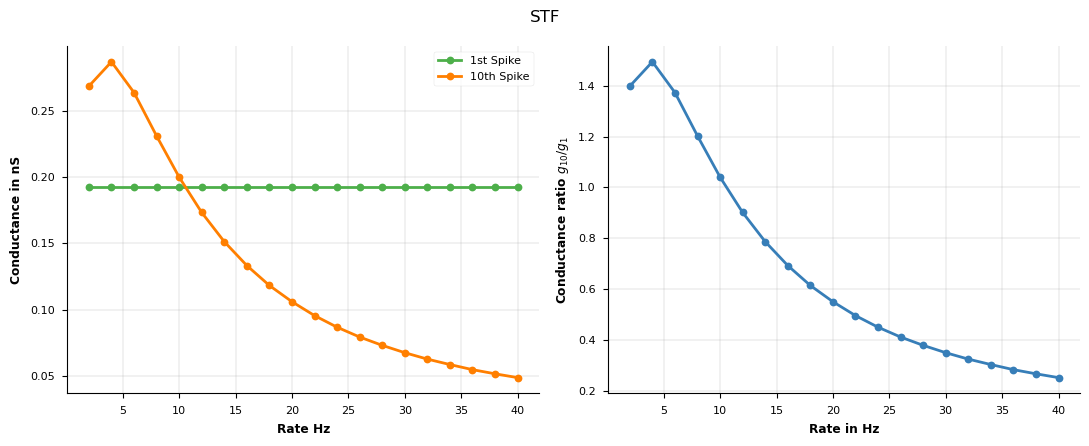

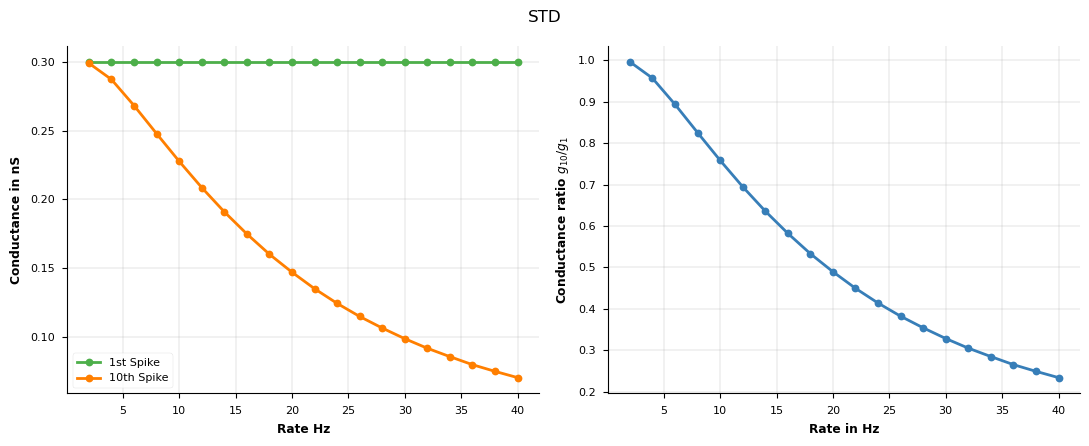

In [64]:
def visualize_g_ratios(g_1, g_10):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 4.5))


    ax1.plot(input_rate, g_1, '-o', color = '#4daf4a', label='1st Spike')
    ax1.plot(input_rate, g_10, '-o', color = '#ff7f00', label='10th Spike')

    ax1.set(
        xlabel = 'Rate Hz',
        ylabel = 'Conductance in nS',
        )
    ax1.legend()


    ax2.plot(input_rate, g_10 / g_1, '-o',color = '#377eb8')
    ax2.set(
        xlabel = 'Rate in Hz',
        ylabel = r'Conductance ratio $g_{10}/g_{1}$',
    )
    

input_rate = np.arange(2., 40.1, 2.)  
stf_g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
stf_g_10 = np.zeros(len(input_rate))  # record the the PSP at 10th spike
    
    
std_g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
std_g_10 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

# std
for ii in range(len(input_rate)):
    std_g_1[ii], std_g_10[ii] = illustrate_STD(
                                rate=input_rate[ii], 
                                U0=0.5, 
                                tau_d=100., 
                                tau_f=50,
                                show_plot=False,)

# stf
for ii in range(len(input_rate)):
    stf_g_1[ii], stf_g_10[ii] = illustrate_STD(
                                rate=input_rate[ii],
                                U0=0.2, 
                                tau_d=100., 
                                tau_f=750.,
                                show_plot=False)
    

visualize_g_ratios(g_1 = stf_g_1, g_10 = stf_g_10)
plt.suptitle('STF')
plt.tight_layout()
visualize_g_ratios(g_1 = std_g_1, g_10 = std_g_10) 
plt.suptitle('STD')
plt.tight_layout()